# **HR Analytics: Prediksi Resign Karyawan untuk Mengurangi Turnover**

**Objektif:**  Menentukan model terbaik dari beberapa classification model untuk memprediksi attrition. Fokus dari proyek ini adalah mengidentifikasi karyawan yang berpeluang untuk resign di periode berikutnya, sehingga metrik yang digunakan yaitu precision untuk meminimalkan nilai FP. Dari analisis tersebut, tim HR bisa membuat strategi retensi untuk mempertahankan karyawan yang akan resign.

## **IMPORT LIBRARIES**

In [1]:
# Import libraries
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import phik
from phik import phik_matrix
import warnings
warnings.filterwarnings('ignore')

# Libraries for Modeling
from sklearn.model_selection import train_test_split # untuk train-test split
from feature_engine.outliers import Winsorizer # untuk handle outlier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder # untuk scaling & encoding
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# Libraries for Model Evaluation
from sklearn.metrics import precision_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

# Saving Model
import pickle

## **DATA LOADING**

In [2]:
os.environ['KAGGLE_CONFIG_DIR'] = os.path.expanduser('~/.kaggle')

# Download dataset
!kaggle datasets download -d stealthtechnologies/employee-attrition-dataset

# Extract file
with zipfile.ZipFile("employee-attrition-dataset.zip", "r") as zip_ref:
    zip_ref.extractall("employee_attrition")

Dataset URL: https://www.kaggle.com/datasets/stealthtechnologies/employee-attrition-dataset
License(s): apache-2.0
employee-attrition-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
dataset = pd.read_csv("employee_attrition/train.csv")

# Menyalin dataset
dataset = dataset.copy()
dataset = pd.DataFrame(dataset)

In [4]:
dataset

,Employee ID,Age,Gender,Years at Company,Job Role,Monthly Income,Work-Life Balance,Job Satisfaction,Performance Rating,Number of Promotions,...,Number of Dependents,Job Level,Company Size,Company Tenure,Remote Work,Leadership Opportunities,Innovation Opportunities,Company Reputation,Employee Recognition,Attrition
0,8410,31,Male,19,Education,5390,Excellent,Medium,Average,2,...,0,Mid,Medium,89,No,No,No,Excellent,Medium,Stayed
1,64756,59,Female,4,Media,5534,Poor,High,Low,3,...,3,Mid,Medium,21,No,No,No,Fair,Low,Stayed
2,30257,24,Female,10,Healthcare,8159,Good,High,Low,0,...,3,Mid,Medium,74,No,No,No,Poor,Low,Stayed
3,65791,36,Female,7,Education,3989,Good,High,High,1,...,2,Mid,Small,50,Yes,No,No,Good,Medium,Stayed
4,65026,56,Male,41,Education,4821,Fair,Very High,Average,0,...,0,Senior,Medium,68,No,No,No,Fair,Medium,Stayed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59593,37195,50,Female,12,Education,4414,Fair,High,Average,1,...,2,Senior,Small,35,No,No,Yes,Poor,Very High,Left
59594,6266,18,Male,4,Healthcare,8040,Fair,High,High,3,...,0,Senior,Medium,73,No,No,No,Fair,Medium,Left
59595,54887,22,Female,14,Technology,7944,Fair,High,High,0,...,2,Entry,Small,29,No,Yes,No,Good,Medium,Stayed
59596,861,23,Male,8,Education,2931,Fair,Very High,Average,0,...,0,Entry,Large,9,No,No,No,Good,Low,Left


In [5]:
dataset.head()

,Employee ID,Age,Gender,Years at Company,Job Role,Monthly Income,Work-Life Balance,Job Satisfaction,Performance Rating,Number of Promotions,...,Number of Dependents,Job Level,Company Size,Company Tenure,Remote Work,Leadership Opportunities,Innovation Opportunities,Company Reputation,Employee Recognition,Attrition
0,8410,31,Male,19,Education,5390,Excellent,Medium,Average,2,...,0,Mid,Medium,89,No,No,No,Excellent,Medium,Stayed
1,64756,59,Female,4,Media,5534,Poor,High,Low,3,...,3,Mid,Medium,21,No,No,No,Fair,Low,Stayed
2,30257,24,Female,10,Healthcare,8159,Good,High,Low,0,...,3,Mid,Medium,74,No,No,No,Poor,Low,Stayed
3,65791,36,Female,7,Education,3989,Good,High,High,1,...,2,Mid,Small,50,Yes,No,No,Good,Medium,Stayed
4,65026,56,Male,41,Education,4821,Fair,Very High,Average,0,...,0,Senior,Medium,68,No,No,No,Fair,Medium,Stayed


In [6]:
dataset.tail()

,Employee ID,Age,Gender,Years at Company,Job Role,Monthly Income,Work-Life Balance,Job Satisfaction,Performance Rating,Number of Promotions,...,Number of Dependents,Job Level,Company Size,Company Tenure,Remote Work,Leadership Opportunities,Innovation Opportunities,Company Reputation,Employee Recognition,Attrition
59593,37195,50,Female,12,Education,4414,Fair,High,Average,1,...,2,Senior,Small,35,No,No,Yes,Poor,Very High,Left
59594,6266,18,Male,4,Healthcare,8040,Fair,High,High,3,...,0,Senior,Medium,73,No,No,No,Fair,Medium,Left
59595,54887,22,Female,14,Technology,7944,Fair,High,High,0,...,2,Entry,Small,29,No,Yes,No,Good,Medium,Stayed
59596,861,23,Male,8,Education,2931,Fair,Very High,Average,0,...,0,Entry,Large,9,No,No,No,Good,Low,Left
59597,15796,56,Male,19,Technology,6660,Good,High,Average,0,...,3,Mid,Medium,81,No,No,No,Good,Low,Stayed


In [7]:
dataset.duplicated().sum()

0

In [8]:
dataset.isnull().sum()

Employee ID                 0
Age                         0
Gender                      0
Years at Company            0
Job Role                    0
Monthly Income              0
Work-Life Balance           0
Job Satisfaction            0
Performance Rating          0
Number of Promotions        0
Overtime                    0
Distance from Home          0
Education Level             0
Marital Status              0
Number of Dependents        0
Job Level                   0
Company Size                0
Company Tenure              0
Remote Work                 0
Leadership Opportunities    0
Innovation Opportunities    0
Company Reputation          0
Employee Recognition        0
Attrition                   0
dtype: int64

In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59598 entries, 0 to 59597
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Employee ID               59598 non-null  int64 
 1   Age                       59598 non-null  int64 
 2   Gender                    59598 non-null  object
 3   Years at Company          59598 non-null  int64 
 4   Job Role                  59598 non-null  object
 5   Monthly Income            59598 non-null  int64 
 6   Work-Life Balance         59598 non-null  object
 7   Job Satisfaction          59598 non-null  object
 8   Performance Rating        59598 non-null  object
 9   Number of Promotions      59598 non-null  int64 
 10  Overtime                  59598 non-null  object
 11  Distance from Home        59598 non-null  int64 
 12  Education Level           59598 non-null  object
 13  Marital Status            59598 non-null  object
 14  Number of Dependents  

Data sudah berhasil di load. Setelah dilakukan eksplorasi sederhana, didapatkan beberapa insight antara lain:
- Data yang didapatan sebanyak 59598 baris dan 24 kolom
- Tidak terdapat missing value pada data
- Tidak terdapat duplikat pada data
- Terdapat 8 kolom bertipe integer, dan 16 kolom bertipe object

Selanjutnya yaitu mengubah nama kolom agar memudahkan saat proses pemanggilan kolom.

In [10]:
# Mengubah nama kolom
dataset.columns = dataset.columns.str.lower().str.replace(' ', '_')
dataset.columns

Index(['employee_id', 'age', 'gender', 'years_at_company', 'job_role',
       'monthly_income', 'work-life_balance', 'job_satisfaction',
       'performance_rating', 'number_of_promotions', 'overtime',
       'distance_from_home', 'education_level', 'marital_status',
       'number_of_dependents', 'job_level', 'company_size', 'company_tenure',
       'remote_work', 'leadership_opportunities', 'innovation_opportunities',
       'company_reputation', 'employee_recognition', 'attrition'],
      dtype='object')

Kolom sudah berhasil diubah. Selanjutnya bisa dilakukan eksplorasi sederhana untuk kolom-kolom yang bertipe integer.

In [11]:
dataset.describe()

,employee_id,age,years_at_company,monthly_income,number_of_promotions,distance_from_home,number_of_dependents,company_tenure
count,59598.000000,59598.000000,59598.000000,59598.000000,59598.000000,59598.000000,59598.000000,59598.000000
mean,37227.118729,38.565875,15.753901,7302.397983,0.832578,50.007651,1.648075,55.758415
std,21519.150028,12.079673,11.245981,2151.457423,0.994991,28.466459,1.555689,25.411090
min,1.000000,18.000000,1.000000,1316.000000,0.000000,1.000000,0.000000,2.000000
25%,18580.250000,28.000000,7.000000,5658.000000,0.000000,25.000000,0.000000,36.000000
50%,37209.500000,39.000000,13.000000,7354.000000,1.000000,50.000000,1.000000,56.000000
75%,55876.750000,49.000000,23.000000,8880.000000,2.000000,75.000000,3.000000,76.000000
max,74498.000000,59.000000,51.000000,16149.000000,4.000000,99.000000,6.000000,128.000000


In [12]:
dataset['number_of_promotions'].value_counts()

number_of_promotions
0    29716
1    14965
2    10884
3     3245
4      788
Name: count, dtype: int64

Dari perhitungan tersebut didapatkan beberapa insight antara lain:
- Rata-rata usia karyawan di perusahaan DEF yaitu 38 tahun, dimana karyawan termuda berusia 18 tahun, dan karyawan tertua berusia 58 tahun
- Kolom number_of_promotions menunjukkan banyaknya seorang karyawan mendapatkan promosi selama bekerja. Dari perhitungan tersebut, masih banyak karyawan yang belum mendapatkan promosi sebanyak sekitar 29700 karyawan
-  Kolom company_tenure menunjukan lamanya seorang karyawan bekerja di industri. Namun, nilai terbesarnya yaitu 128 tahun yang tidak mungkin terjadi dan dapat mengindikasikan adanya outlier

## **EXPLORATORY DATA ANALYSIS (EDA)**

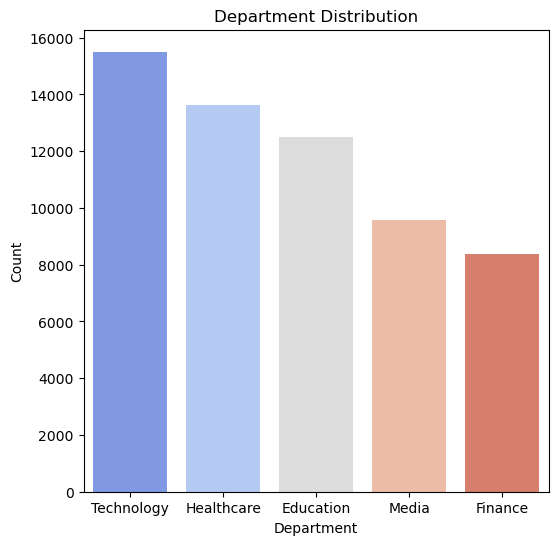

In [13]:
job = dataset["job_role"].value_counts()

plt.figure(figsize = (6, 6))
sns.barplot(x = job.index, y = job.values, palette = 'coolwarm')
plt.xlabel("Department")
plt.ylabel("Count")
plt.title("Department Distribution")
plt.show()

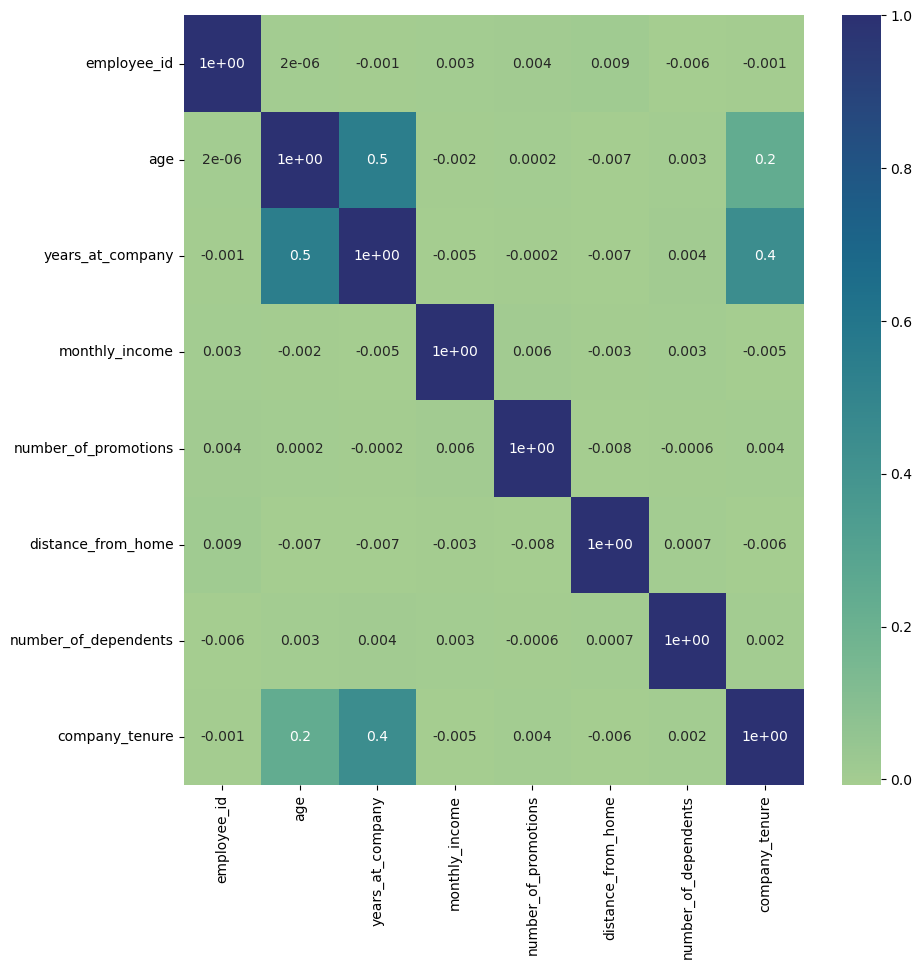

In [14]:
corr = dataset.corr(numeric_only = True)
plt.figure(figsize = (10, 10))
sns.heatmap(corr, annot = True, fmt = '.1', cmap = 'crest')
plt.show()

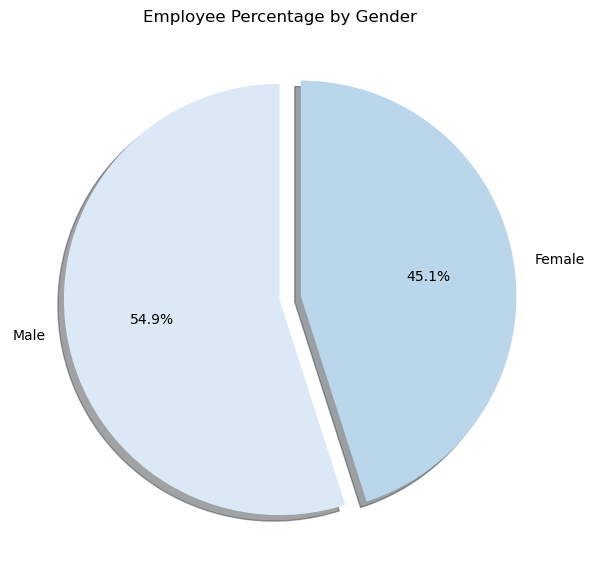

In [15]:
gender = dataset["gender"].value_counts()

plt.figure(figsize = (7, 7))
plt.pie(
    x = gender.values,
    labels = gender.index,
    explode = [0, 0.1],
    colors = sns.color_palette('Blues'),
    autopct = '%1.1f%%',
    startangle = 90,
    shadow = True
)
plt.title("Employee Percentage by Gender")
plt.show()

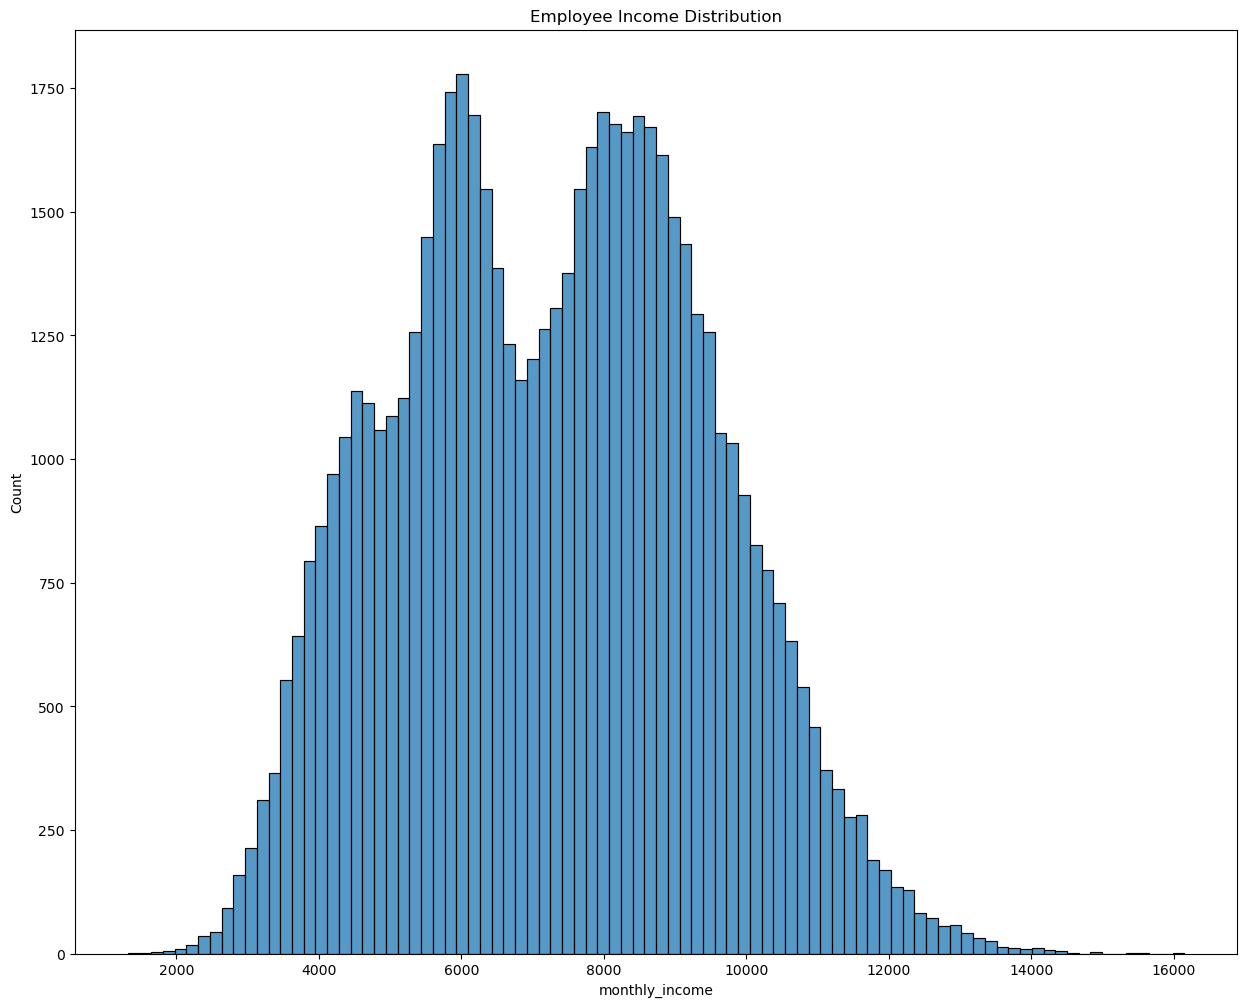

In [16]:
plt.figure(figsize = (15,12))
sns.histplot(data = dataset, x = "monthly_income")
plt.title("Employee Income Distribution")
plt.show()

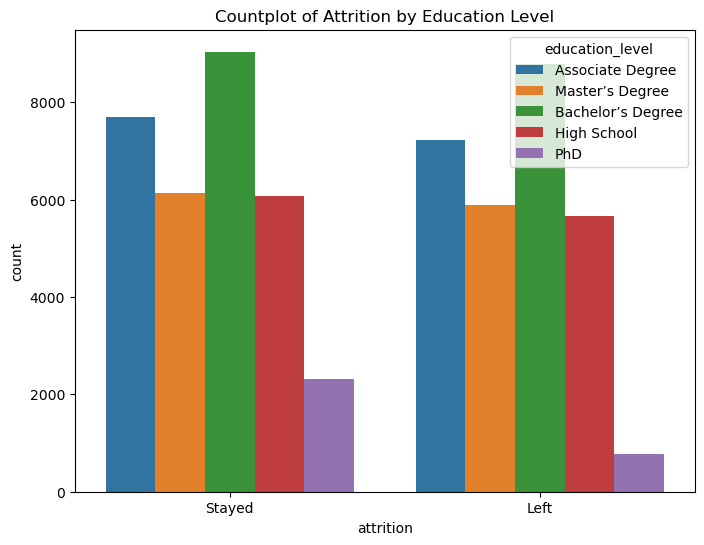

In [17]:
plt.figure(figsize = (8, 6))
sns.countplot(dataset, x = "attrition", hue = "education_level")
plt.title("Countplot of Attrition by Education Level")
plt.show()

## **DATA PREPROCESSING**

### **Data Preparation**

In [18]:
# Split dataset antara label (X) dan target (y)
X = dataset.drop(columns = 'attrition')
y = dataset.attrition

In [19]:
# Split antara train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 500)
print(f"Train size: {X_train.shape}")
print(f"Test size: {X_test.shape}")
X_train.head()

Train size: (47678, 23)
Test size: (11920, 23)


,employee_id,age,gender,years_at_company,job_role,monthly_income,work-life_balance,job_satisfaction,performance_rating,number_of_promotions,...,marital_status,number_of_dependents,job_level,company_size,company_tenure,remote_work,leadership_opportunities,innovation_opportunities,company_reputation,employee_recognition
53718,19157,51,Female,39,Media,5596,Poor,High,Average,1,...,Single,0,Entry,Medium,77,No,Yes,No,Fair,Medium
32137,19025,58,Male,17,Education,3711,Fair,High,Average,1,...,Single,0,Entry,Large,65,No,No,No,Fair,High
20293,17852,57,Male,13,Technology,10063,Excellent,High,Average,0,...,Married,0,Mid,Medium,40,No,No,No,Fair,Low
36690,71116,33,Female,19,Healthcare,7173,Fair,Medium,Below Average,0,...,Married,1,Mid,Medium,23,No,No,No,Fair,High
5605,29821,44,Female,11,Healthcare,8199,Excellent,Medium,High,0,...,Married,2,Entry,Small,62,Yes,No,No,Good,Low


Dari proses split data didapatkan variabel baru. Dimana data train sebanyak 47678 data, dan data test sebanyak 11920 data.

### **Data Cleaning**

#### **Handling Missing Value**

In [20]:
X_train.isnull().sum()

employee_id                 0
age                         0
gender                      0
years_at_company            0
job_role                    0
monthly_income              0
work-life_balance           0
job_satisfaction            0
performance_rating          0
number_of_promotions        0
overtime                    0
distance_from_home          0
education_level             0
marital_status              0
number_of_dependents        0
job_level                   0
company_size                0
company_tenure              0
remote_work                 0
leadership_opportunities    0
innovation_opportunities    0
company_reputation          0
employee_recognition        0
dtype: int64

In [21]:
X_test.isnull().sum()

employee_id                 0
age                         0
gender                      0
years_at_company            0
job_role                    0
monthly_income              0
work-life_balance           0
job_satisfaction            0
performance_rating          0
number_of_promotions        0
overtime                    0
distance_from_home          0
education_level             0
marital_status              0
number_of_dependents        0
job_level                   0
company_size                0
company_tenure              0
remote_work                 0
leadership_opportunities    0
innovation_opportunities    0
company_reputation          0
employee_recognition        0
dtype: int64

Tidak terdapat missing value pada data train maupun data test.

#### **Handling Outliers**

Handling outlier dilakukan pada fitur-fitur bertipe numerikal saja.

In [22]:
outlier = ["age", "years_at_company", "monthly_income", "distance_from_home", "number_of_dependents", "company_tenure"]

for i in outlier:
    skew = X_train[i].skew()
    prompt = "Normal Distribution" if -0.5 < skew < 0.5 else "Skew"
    print(f"{i}: {skew} {prompt}")

age: -0.004506735651175281 Normal Distribution
years_at_company: 0.789380584037643 Skew
monthly_income: 0.11392095026025544 Normal Distribution
distance_from_home: -0.002460938674752696 Normal Distribution
number_of_dependents: 0.7165713274697143 Skew
company_tenure: 0.07272278922888949 Normal Distribution


**Pengecekan Upper & Lower**

In [23]:
# Define a function to detect outliers in a normal distribution
def normal_boundaries(dataset, variable):
    upper_boundary_norm = dataset[variable].mean() + 3 * dataset[variable].std()
    lower_boundary_norm = dataset[variable].mean() - 3 * dataset[variable].std()

    return upper_boundary_norm, lower_boundary_norm

In [24]:
norm = ["age", "monthly_income", "distance_from_home", "company_tenure"]

for i in norm:
    upper_boundary_norm, lower_boundary_norm = normal_boundaries(X_train, [i])
    print(f"Upper & Lower boundary {i}: {upper_boundary_norm.values[0]}, {lower_boundary_norm.values[0]}")

Upper & Lower boundary age: 74.75960742710694, 2.316024940022558
Upper & Lower boundary monthly_income: 13753.138308933387, 844.3410316429799
Upper & Lower boundary distance_from_home: 135.56220909440012, -35.324992768211935
Upper & Lower boundary company_tenure: 131.96477491861566, -20.66472038612688


In [25]:
# Define a function to detect outliers in a skew
def skew_boundaries(dataset, variable, distance):
    IQR = dataset[variable].quantile(0.75) - dataset[variable].quantile(0.25)

    lower_boundary_skew = dataset[variable].quantile(0.25) - (IQR * distance)
    upper_boundary_skew = dataset[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary_skew, lower_boundary_skew  

In [26]:
skew = ["years_at_company", "number_of_dependents"]

for i in skew:
    upper_boundary_skew, lower_boundary_skew = skew_boundaries(X_train, [i], 3)
    print(f"Upper & Lower boundary {i}: {upper_boundary_skew.values[0]}, {lower_boundary_skew.values[0]}")

Upper & Lower boundary years_at_company: 71.0, -41.0
Upper & Lower boundary number_of_dependents: 12.0, -9.0


**Capping Outliers**

In [27]:
# Define a function to make a boxplot
def diagnostic_plots(dataset_before, dataset_after, variable):
    plt.figure(figsize = (10, 5))
    
    # Before capping
    plt.subplot(1, 2, 1)
    sns.boxplot(y = dataset_before[variable])
    plt.title(f"\n {variable} - Before Capping")

    # After capping
    plt.subplot(1, 2, 2)
    sns.boxplot(y = dataset_after[variable])
    plt.title(f"\n {variable} - After Capping")

    plt.tight_layout()
    plt.show()

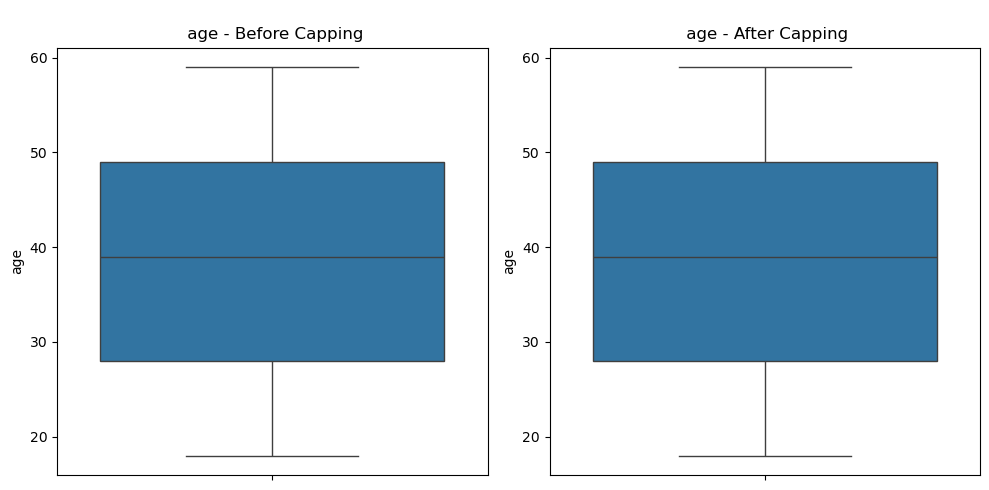

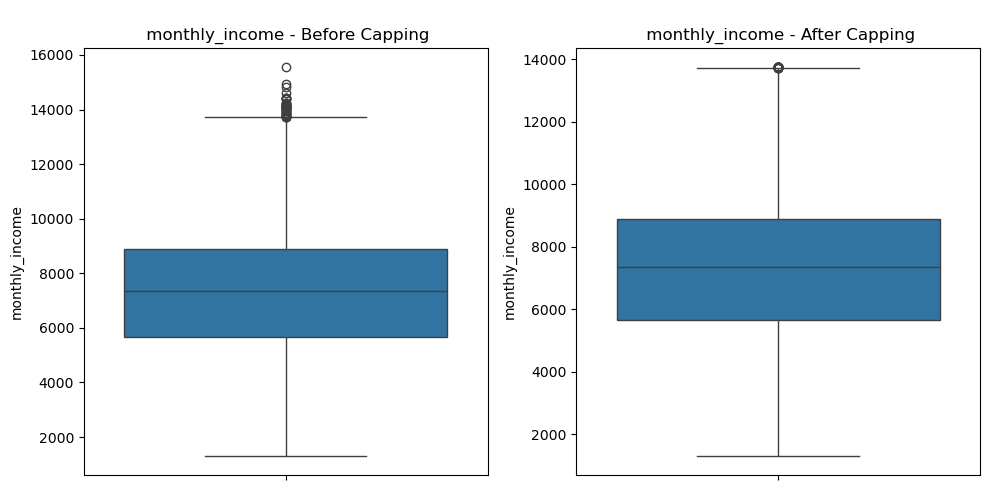

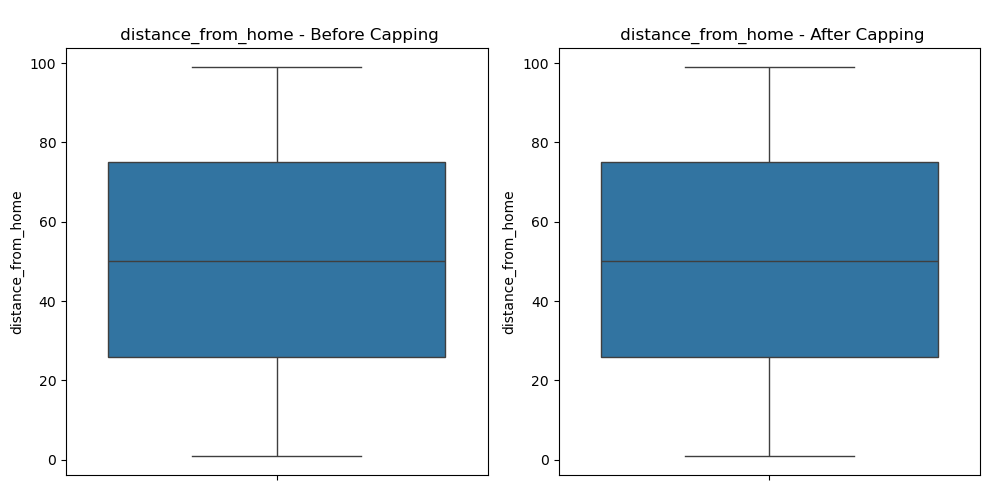

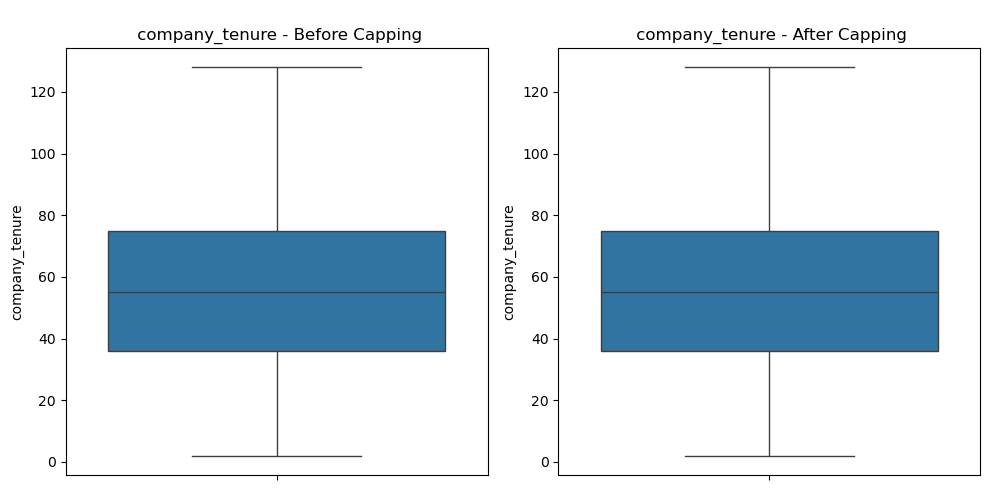

In [28]:
# Handling outliers in a normal distribution
for i in norm:
    winsorizer_norm = Winsorizer(capping_method = 'gaussian',
                                 tail = 'both',
                                 fold = 3,
                                 variables = [i],
                                 missing_values = 'ignore')
    
    X_train_capped = winsorizer_norm.fit_transform(X_train)
    X_test_capped = winsorizer_norm.transform(X_test)

    # Show the plot
    diagnostic_plots(X_train, X_train_capped, i)

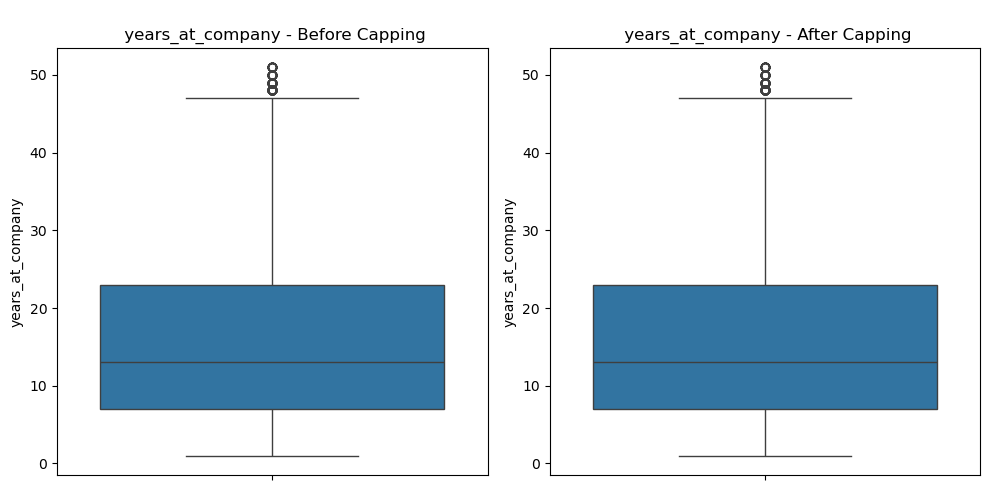

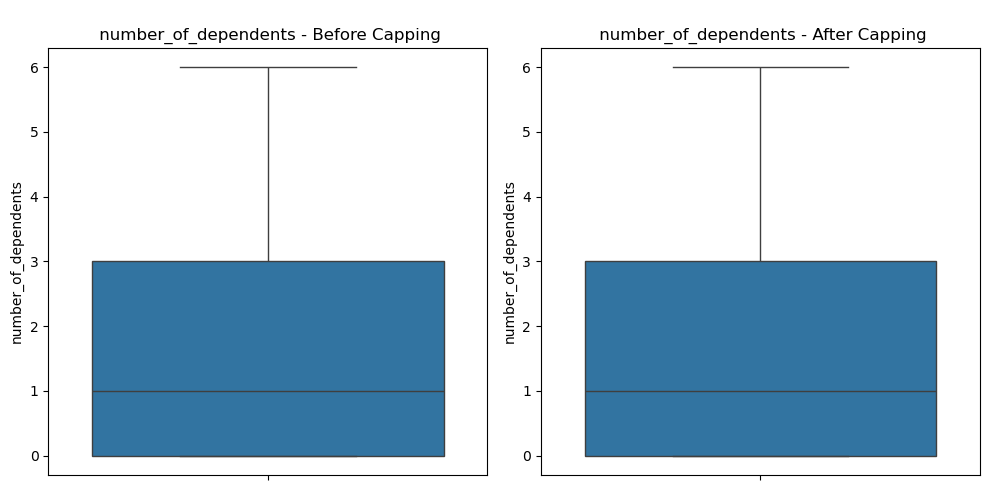

In [29]:
# Handling outliers in a skew
for i in skew:
    winsorizer_skew = Winsorizer(capping_method = 'iqr',
                                 tail = 'both',
                                 fold = 3,
                                 variables = [i])
    
    X_train_capped = winsorizer_skew.fit_transform(X_train_capped)
    X_test_capped = winsorizer_skew.transform(X_test_capped)

    # Show the plot
    diagnostic_plots(X_train, X_train_capped, i)

Dari proses capping tersebut, ada hal menarik dimana capping hanya dilakukan pada fitur bertipe continue. Sementara pada fitur diskrit tidak ada perubahan pada nilainya. Hal ini bisa terjadi karena fitur continue memiliki rentang nilai yang luas, sehingga outlier biasanya merupakan nilai yang rentangnya jauh dari mayoritas data. Sementara pada fitur diskrit, outlier lebih sering muncul dalam bentuk nilai yang jarang atau tidak wajar, bukan karena perbedaannya yang terlalu jauh dari nilai lainnya. Oleh karena itu, capping pada fitur diskrit akan dibiarkan seperti hasilnya.

### **Feature Selection**

**Phik Correlation**

interval columns not set, guessing: ['employee_id', 'age', 'years_at_company', 'monthly_income', 'number_of_promotions', 'distance_from_home', 'number_of_dependents', 'company_tenure']


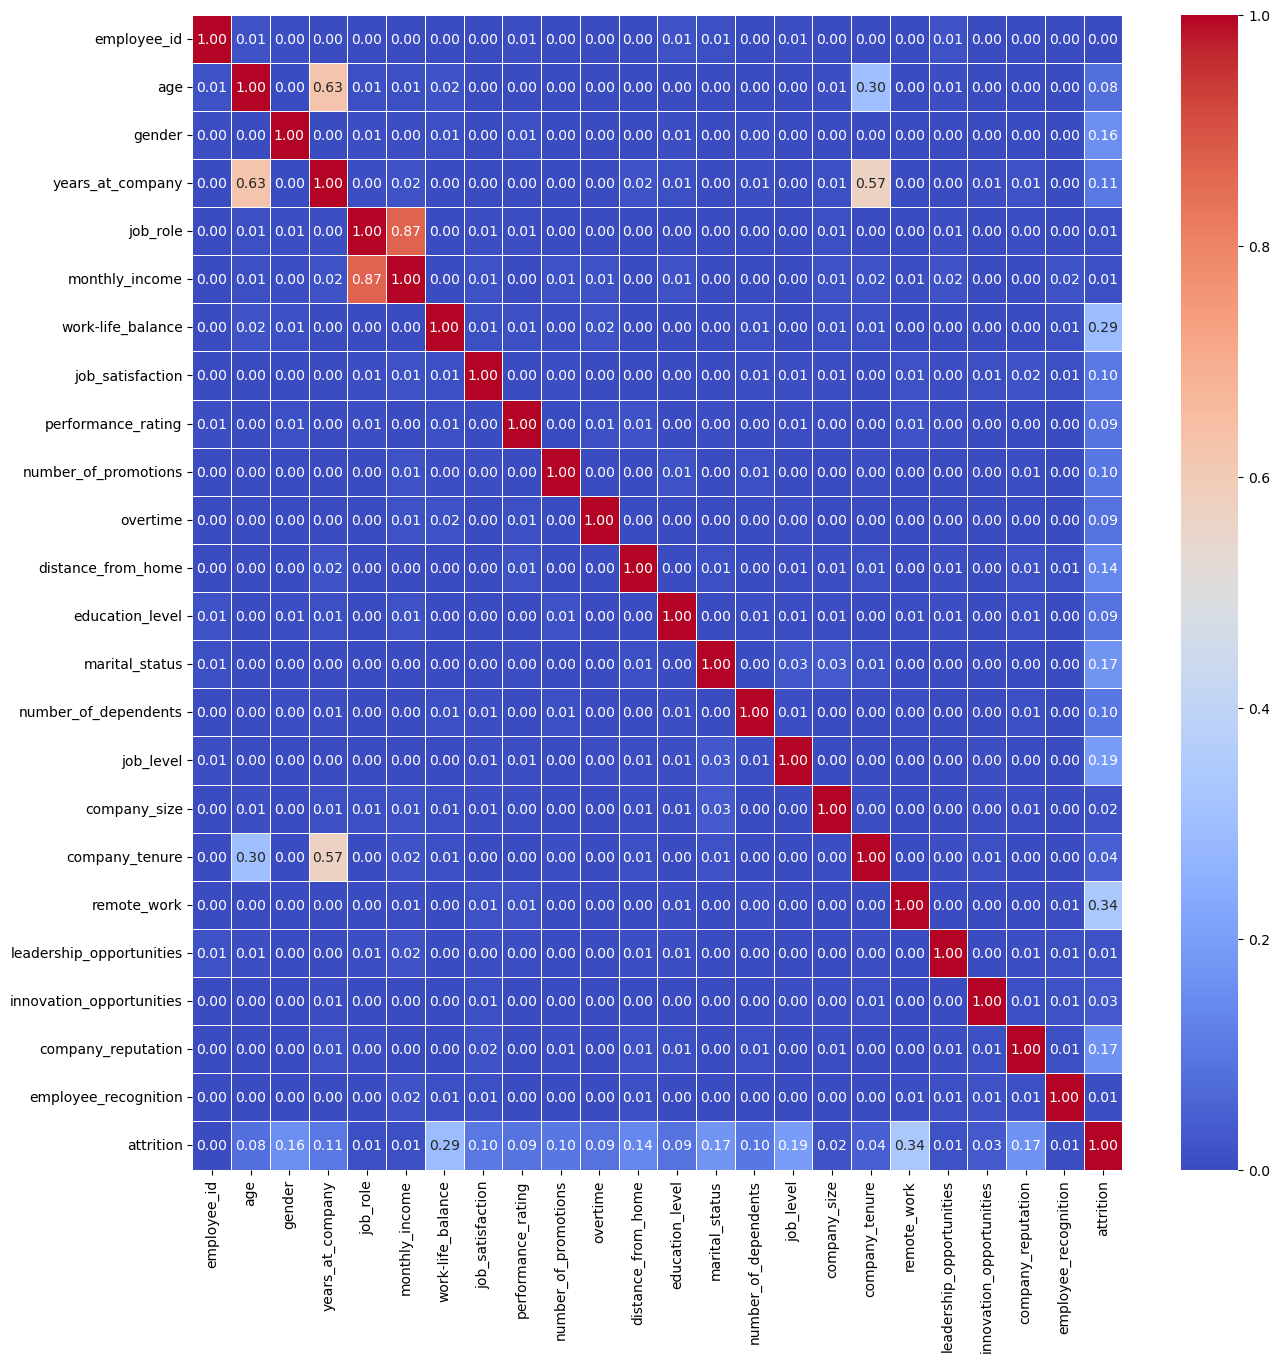

In [30]:
phik_corr = dataset.phik_matrix()

plt.figure(figsize = (15, 15))
sns.heatmap(phik_corr, annot = True, fmt = '.2f', cmap = 'coolwarm', linewidths = 0.5)
plt.show()

Dari heatmap korelasi tersebut, dapat dilihat bahwa tidak banyak fitur-fitur yang berkorelasi terhadap target. Bahkan nilainya juga sangat kecil. Oleh karena itu, saya memutuskan untuk mempertahankan beberapa fitur berdasarkan domain knowledge.

**Cardinality Check**

Cardinality check dilakukan pada fitur kategorikal untuk menentukan jenis encoding yang tepat, karena jumlah fitur yang terlalu banyak bisa berpengaruh pada performa model.

In [31]:
for i in dataset:
    if i == "attrition":
        continue

    if dataset[i].dtype == 'object': # cardinality check only for categorical features
        print(f"{i}: {dataset[i].unique()}")

gender: ['Male' 'Female']
job_role: ['Education' 'Media' 'Healthcare' 'Technology' 'Finance']
work-life_balance: ['Excellent' 'Poor' 'Good' 'Fair']
job_satisfaction: ['Medium' 'High' 'Very High' 'Low']
performance_rating: ['Average' 'Low' 'High' 'Below Average']
overtime: ['No' 'Yes']
education_level: ['Associate Degree' 'Master’s Degree' 'Bachelor’s Degree' 'High School'
 'PhD']
marital_status: ['Married' 'Divorced' 'Single']
job_level: ['Mid' 'Senior' 'Entry']
company_size: ['Medium' 'Small' 'Large']
remote_work: ['No' 'Yes']
leadership_opportunities: ['No' 'Yes']
innovation_opportunities: ['No' 'Yes']
company_reputation: ['Excellent' 'Fair' 'Poor' 'Good']
employee_recognition: ['Medium' 'Low' 'High' 'Very High']


Dari hasil analisis cardinality, dapat disimpulkan bahwa tidak ada fitur dengan high cardinality. Sehingga untuk proses encoding dapat disesuaikan berdasarkan jenis kategori dari masing-masing fitur. Selain itu, kita juga dapat menentukan fitur-fitur mana saja yang perlu dihapus. Saya memutuskan untuk menghapus fitur employee_id karena semua nilainya unik, serta fitur-fitur lain seperti performance_rating, company_size, remote_work, leadership_opportunities, innovation_opportunities, company_reputation, dan employee_recognition. Sementara untuk fitur bertipe numerikal saya memutuskan untuk menghapus fitur company_tenure, karena fokus dari proyek ini untuk memprediksi attrition pada perusahaan DEF.

In [32]:
# Drop the features
X_train_capped.drop(["employee_id", "performance_rating", "company_size", "remote_work", "leadership_opportunities", "innovation_opportunities", "company_reputation", "employee_recognition", "company_tenure"], axis = 1, inplace = True)
X_test_capped.drop(["employee_id", "performance_rating", "company_size", "remote_work", "leadership_opportunities", "innovation_opportunities", "company_reputation", "employee_recognition", "company_tenure"], axis = 1, inplace = True)
print(X_train_capped.columns)

Index(['age', 'gender', 'years_at_company', 'job_role', 'monthly_income',
       'work-life_balance', 'job_satisfaction', 'number_of_promotions',
       'overtime', 'distance_from_home', 'education_level', 'marital_status',
       'number_of_dependents', 'job_level'],
      dtype='object')


In [33]:
X_train_capped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47678 entries, 53718 to 17335
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   age                   47678 non-null  int64 
 1   gender                47678 non-null  object
 2   years_at_company      47678 non-null  int64 
 3   job_role              47678 non-null  object
 4   monthly_income        47678 non-null  int64 
 5   work-life_balance     47678 non-null  object
 6   job_satisfaction      47678 non-null  object
 7   number_of_promotions  47678 non-null  int64 
 8   overtime              47678 non-null  object
 9   distance_from_home    47678 non-null  int64 
 10  education_level       47678 non-null  object
 11  marital_status        47678 non-null  object
 12  number_of_dependents  47678 non-null  int64 
 13  job_level             47678 non-null  object
dtypes: int64(6), object(8)
memory usage: 5.5+ MB


Fitur sudah berhasil di drop. Selanjutnya menentukan jenis scaling dan encoding pada masing-masing fitur.

### **Feature Transformation**

**Encoding the labels using `LabelEncoder`**

Seperti yang diketahui bahwa model machine learning hanya bekerja dengan nilai numerik, bukan string. Sehingga kolom y untuk data train dan test perlu dilakukan encoding. Karena jika label masih berupa string "Left" dan "Stayed", model tidak akan bisa memprosesnya. 

In [34]:
le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [35]:
print(le.classes_)

['Left' 'Stayed']


In [36]:
print(le.transform(["Left", "Stayed"]))

[0 1]


**Encoding and scaling features using `ColumnTransformer`**

In [37]:
num = ["age", "years_at_company", "monthly_income", "distance_from_home"]
cat = ["gender", "job_role", "work-life_balance", "job_satisfaction", "number_of_promotions", "overtime", "education_level", "marital_status", "job_level", "number_of_dependents"]

In [38]:
scaler = StandardScaler()
encoder = OneHotEncoder(sparse_output = False, handle_unknown = 'ignore')

preprocess = ColumnTransformer(
    transformers = [
        ("num", scaler, num),
        ["cat", encoder, cat]],
    remainder = 'drop'
)

## **MODELING**

Pada bagian ini, saya akan melakukan cross validation dengan menggunakan beberapa model machine learning antara lain Support Vector Classifier, K-Nearest Neighbor, Decision Tree, serta ensemble model seperti Random Forest dan AdaBoost Classifier. Dari beberapa model tersebut, performanya akan diuji untuk menentukan model terbaik yang paling optimal untuk proyek ini.

In [39]:
pipe_knn = Pipeline([
    ("preprocess", preprocess),
    ("model_knn", KNeighborsClassifier())
])

In [40]:
pipe_svc = Pipeline([
    ("preprocess", preprocess),
    ("model_svc", SVC())
])

In [41]:
pipe_dt = Pipeline([
    ("preprocess", preprocess),
    ("model_dt", DecisionTreeClassifier(random_state = 100))
])

In [42]:
pipe_rf = Pipeline([
    ("preprocess", preprocess),
    ("model_rf", RandomForestClassifier(random_state = 100))
])

In [43]:
pipe_ada = Pipeline([
    ("preprocess", preprocess),
    ("model_ada", AdaBoostClassifier())
])

### **Cross Validation**

Cross validation merupakan teknik evaluasi model dengan cara membagi dataset menjadi beberapa subset, sehingga model yang diuji lebih menyeluruh. Cara kerja cross validation, kita akan membagi data menjadi 'k' kelompok yang seimbang. Setiap kelompok nantinya akan mendapatkan giliran untuk menjadi data uji, sementara kelompok-kelompok lainnya akan menjadi data latih.

In [44]:
# Set the kfold
skfold = StratifiedKFold(n_splits = 5)

# Define the cross validation for each model
cv_knn = cross_val_score(pipe_knn, X_train_capped, y_train, cv = skfold, scoring = 'precision', n_jobs = -1)
cv_svc = cross_val_score(pipe_svc, X_train_capped, y_train, cv = skfold, scoring = 'precision', n_jobs = -1)
cv_dt = cross_val_score(pipe_dt, X_train_capped, y_train, cv = skfold, scoring = 'precision', n_jobs = -1)
cv_rf = cross_val_score(pipe_rf, X_train_capped, y_train, cv = skfold, scoring = 'precision', n_jobs = -1)
cv_ada = cross_val_score(pipe_ada, X_train_capped, y_train, cv = skfold, scoring = 'precision', n_jobs = -1)

In [45]:
name_model = []
cv_scores = 0

# Choose best model
for cv, name in zip([cv_knn, cv_svc, cv_dt, cv_rf, cv_ada],
                    ["knn_model", "svc_model", "dt_model", "rf_model", "ada_model"]):
    print(name)
    print("Precision score - All (Cross Validation):", [round(score, 2) for score in cv])
    print("Precision score - Mean (Cross Validation):", round(cv.mean(), 2))
    print("Precision score - Std (Cross Validation):", round(cv.std(), 2))
    print("Precision score - Range of test set:", round(cv.mean()-cv.std(), 2), "-" , round(cv.mean()+cv.std(), 2))
    print("-"* 50)
    if cv.mean() > cv_scores:
        cv_scores = cv.mean()
        name_model = name
    else:
        pass

# Show best model
print("Best model:", name_model)
print("Cross validation mean from best model:", round(cv_scores, 2))

knn_model
Precision score - All (Cross Validation): [0.69, 0.68, 0.69, 0.69, 0.68]
Precision score - Mean (Cross Validation): 0.68
Precision score - Std (Cross Validation): 0.0
Precision score - Range of test set: 0.68 - 0.69
--------------------------------------------------
svc_model
Precision score - All (Cross Validation): [0.73, 0.73, 0.73, 0.74, 0.73]
Precision score - Mean (Cross Validation): 0.73
Precision score - Std (Cross Validation): 0.0
Precision score - Range of test set: 0.73 - 0.73
--------------------------------------------------
dt_model
Precision score - All (Cross Validation): [0.66, 0.65, 0.66, 0.66, 0.65]
Precision score - Mean (Cross Validation): 0.65
Precision score - Std (Cross Validation): 0.0
Precision score - Range of test set: 0.65 - 0.66
--------------------------------------------------
rf_model
Precision score - All (Cross Validation): [0.73, 0.72, 0.72, 0.73, 0.72]
Precision score - Mean (Cross Validation): 0.72
Precision score - Std (Cross Validation)

Dari perhitungan cross validation, dapat dilihat bahwa pada model AdaBoost Classifier dan Support Vector CLassifier memiliki rata-rata precision yang sama, yaitu 0.73. Namun, jika dilihat dari rentang score pada data test, model AdaBoost memiliki performa yang lebih unggul daripada Support Vector CLassifier. Oleh karena itu, best model yang dipilih adalah **AdaBoost Classifier**.

## **TRAINING**

Ensemble learning merupakan teknik dalam machine learning yang menggabungkan beberapa model (biasanya disebut weak learners atau base models) untuk menghasilkan model prediksi yang lebih akurat. Ada tiga jenis utama dari ensemble learning, salah satunya yaitu boosting. Cara kerja dari teknik Boosting yaitu membangun sebuah model untuk memperbaiki kesalahan yang ada pada model pertama. Jadi, prinsipnya adalah menggabungkan beberapa model (weak learner) untuk menjadi sebuah model yang dapat memprediksi dengan benar.  

**AdaBoost Classifier** merupakan salah satu model dari teknik boosting. Model ini bekerja dengan cara menggabungkan beberapa weak learners (biasanya decision tree dengan depth rendah) secara bertahap. Kesalahan dari model pertama akan diberikan bobot yang lebih besar, sehingga model berikutnya akan lebih fokus pada data yang sulit diklasifikasikan.

AdaBoost Classifier memiliki kelebihan dan kekurangan, **kelebihan**:
- Mudah untuk diimplementasikan
- Memperbaiki kesalahan dari classifier yang lemah dan meningkatkan akurasi dengan menggabungkan beberapa weak learners
- Bisa menggunakan beberapa base classifiers pada AdaBoost
- Tidak rentan terhadap overfitting  

**Kelemahan**:
- Sensitif terhadap noise data
- Sangat dipengaruhi oleh outlier
- Lebih lambat jika dibandingkan dengan XGBoost


[Artikel 1](https://www.trivusi.web.id/2023/07/algoritma-adaboost.html)  
[Artikel 2](https://www.kaggle.com/code/prashant111/adaboost-classifier-tutorial)  
[Artikel 3](https://kantinit.com/kecerdasan-buatan/apa-itu-agoritma-adaboost-pengertian-cara-kerja-dan-contoh/)

In [46]:
pipe_ada.fit(X_train_capped, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'years_at_company',
                                                   'monthly_income',
                                                   'distance_from_home']),
                                                 ['cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['gender', 'job_role',
                                                   'work-life_balance',
                                                   'job_satisfaction',
                                                   'number_of_promotions',
                                                   'overtime',
                                                   'education_level',
                                                   'marital_status',
                                                   'job_level',
                                                   'number_of_dependents']]])),
                ('model_ada', AdaBoostClassifier())])

In [47]:
y_pred_train = pipe_ada.predict(X_train_capped)
y_pred_test = pipe_ada.predict(X_test_capped)

## **MODEL EVALUATION**

### **Confusion Matrix**

In [48]:
# Define a metrics evaluation (confussion matrix)
def cm_display(model, X_train, y_train, X_test, y_test):
    fig, axes = plt.subplots(1, 2, figsize = (12, 6))

    # Data Train
    cm_train = ConfusionMatrixDisplay.from_estimator(model, X_train, y_train, cmap = 'Greens', ax = axes[0])
    cm_train.ax_.set_title("AdaBoostClassifier (Data Train)")

    # Data Test
    cm_test = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap = 'Greens', ax = axes[1])
    cm_test.ax_.set_title("AdaBoostClassifier (Data Train)")

    plt.tight_layout()
    plt.show()

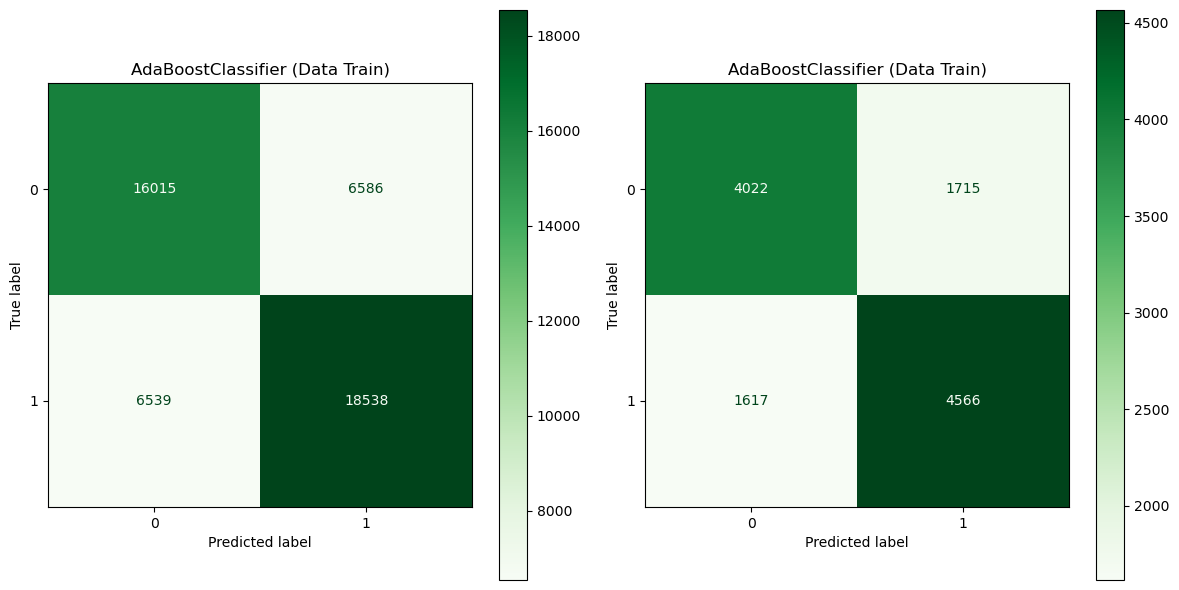

In [49]:
ada_cm = cm_display(pipe_ada, X_train_capped, y_train, X_test_capped, y_test)
ada_cm

Gambar tersebut merupakan hasil dari confusion matrix untuk data train dan test. Berdasarkan target, **left prediksi negatif**, dan **stayed prediksi positif**. Selanjutnya kita lakukan analisis sederhana pada confusion matrix data test, dari gambar tersebut didapatkan insight berikut:
- Nilai TP dari confusion matrix tersebut adalah 4566, artinya model berhasil memprediksi karyawan yang benar-benar tetap bertahan di perusahaan sebanyak 4566 kali
- Nilai TN yaitu 4022, artinya model berhasil memprediksi karyawan yang benar-benar akan resign sebanyak 4022 kali
- Nilai FP yaitu 1715, artinya model memprediksi karyawan yang sebenarnya akan resign, tapi terprediksi tetap di perusahaan sebanyak 1715 kali
- Nilai FN yaitu 1617, artinya model memprediksi karyawan sebenarnya tetap di perusahaan, tapi terprediksi resign sebanyak 1617 kali

Dari hasil tersebut, dapat dilihat bahwa nilai FP masih cukup tinggi. Meskipun selisih antara FP dan FN hanya 98, hal ini menunjukkan bahwa model tidak terlalu bias ke salah satu sisi, baik dalam memprediksi terlalu banyak nilai positif maupun negatif. Pada proses train-test split, data telah dibagi menjadi data train dan test, dengan jumlah data test sebanyak 11920. Berdasarkan jumlah FP yang masih besar, ini menunjukkan bahwa error rate model masih cukup tinggi dan perlu perbaikan untuk meningkatkan performanya. Kemungkinan hal ini disebabkan karena model masih menggunakan parameter default, sehingga masih belum optimal untuk tujuan proyek ini. Oleh karena itu, setelah memeriksa score performa model, saya akan melakukan hyperparameter tuning untuk mendapatkan model dengan performa terbaik dalam meminimalkan nilai FP. 

### **Precision**

Fokus dari proyek ini yaitu memprediksi karyawan yang akan resign, sehingga metrik evaluasi yang digunakan adalah precision. Pada proyek ini, precision menunjukkan seberapa baik model dalam memprediksi karyawan yang akan resign (dengan meminimalkan nilai FP), semakin tinggi score-nya maka semakin bagus performa model.

In [50]:
# Precision
print("Precision score - Train set:", round(precision_score(y_train, y_pred_train), 2))
print("Precision score - Test set:", round(precision_score(y_test, y_pred_test), 2))

Precision score - Train set: 0.74
Precision score - Test set: 0.73


Dari perhitungan score precision, baik data train maupun data test menunjukkan score yang hampir sama, yaitu 0.74 dan 0.73. Hal ini menunjukkan bahwa model memiliki performa yang konsisten pada data train dan test. Dari score tersebut dapat disimpulkan bahwa **model berhasil memprediksi karyawan yang akan resign sebesar 73%**. Meskipun ini sudah menunjukkan performa yang cukup baik, namun masih perlu dioptimalkan lagi dengan hyperparameter tuning untuk mendapatkan score precision yang lebih tinggi.

**Simpan hasil perhitungan**

In [51]:
# Define a function to save the precision result
def performance_report(all_reports, y_train, y_pred_train, y_test, y_pred_test, name):
 
    score_reports = {
        'Precision Train Set': round(precision_score(y_train, y_pred_train), 2),
        'Precision Test Set': round(precision_score(y_test, y_pred_test), 2)
    }

    cm_train = confusion_matrix(y_train, y_pred_train)
    cm_test = confusion_matrix(y_test, y_pred_test)

    score_reports['False Positive Train'] = cm_train[0, 1]
    score_reports['False Positive Test'] = cm_test[0, 1]

    # Save to dictionary
    all_reports[name] = score_reports
    return all_reports

In [52]:
all_reports = {}
all_reports = performance_report(all_reports, y_train, y_pred_train, y_test, y_pred_test, "Model without Tuning")

# Saved as a pandas DataFrame
pd.DataFrame(all_reports)

,Model without Tuning
Precision Train Set,0.74
Precision Test Set,0.73
False Positive Train,6586.00
False Positive Test,1715.00


### **ROC-AUC**

Jika precision digunakan untuk mengukur performa model dalam meminimalkan nilai FP, ROC-AUC digunakan untuk mengukur performa model dalam membedakan kedua kelas. Interpretasi dari AUC yaitu semakin tinggi nilainya dari rentang 0 hingga 1, maka semakin bagus model dalam membedakan kedua kelas. Model cenderung stabil dan dapat digunakan untuk mengklasifikasi dua kelas.

In [53]:
# Define a function to calculate ROC-AUC
def roc_auc(model, X_test, y_test):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)

    # Check the model's performance
    if auc > 0.9:
        print(f"(Score: {auc: .2f}) Good")
    elif 0.8 <= auc <= 0.9:
        print(f"(Score: {auc: .2f}) Fair")
    elif 0.7 <= auc <= 0.8:
        print(f"(Score: {auc: .2f}) Decent")
    elif 0.6 <= auc <= 0.7:
        print(f"(Score: {auc: .2f}) Not Great")
    else:
        print(f"(Score: {auc: .2f}) Poor")

    # Plot ROC-AUC Curve
    plt.figure(0).clf()
    plt.plot(fpr, tpr, label = f"AUC Score= {auc: .2f}")
    plt.plot([0, 1], [0, 1], linestyle = '--')
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("ROC-AUC Curve")
    plt.legend(loc = 0)
    plt.grid(True)
    plt.show()

(Score:  0.81) Fair


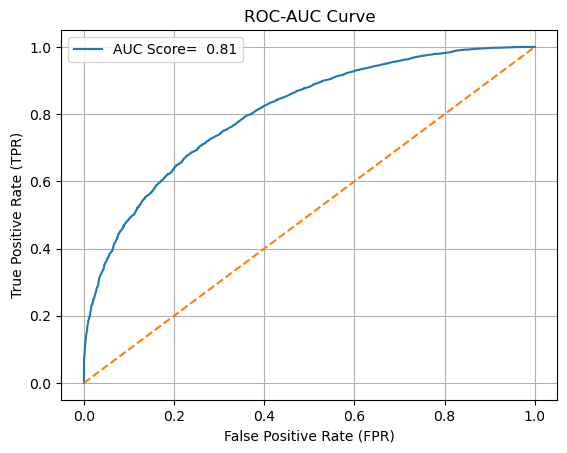

In [54]:
ada_score = roc_auc(pipe_ada, X_test_capped, y_test)
ada_score

Dari perhitungan tersebut, didapatkan AUC score sebesar 0.81. Artinya model sudah berhasil membedakan kedua kelas dengan score 81%. Hasil yang didapatkan sudah bagus, namun masih bisa ditingkatkan lagi dengan melakukan hyperparameter tuning untuk mengoptimalkan performa model.

### **Hyperparameter Tuning - Training**

Dari yang sudah saya pelajari, hyperparameter pada model AdaBoost yaitu:
- **estimator**: merupakan base model. Secara default, AdaBoost menggunakan model decision tree dengan kedalaman rendah (max_depth = 1)
- **n_estimators**: menunjukkan jumlah weak learners. Semakin besar nilainya, semakin kompleks model yang dapat meningkatkan akurasi, tetapi membutuhkan waktu yang lebih lama. Namun, jika terlalu besar, rentan terhadap overfitting
- **learning_rate**: untuk mengontrol seberapa besar kontribusi weak learners terhadap prediksi akhir. Nilai yang kecil akan membuat model belajar lebih lambat, namun lebih stabil. Sementara nilai yang besar membuat model belajar lebih cepat, namun dapat menyebabkan overfitting.

[Artikel 4](https://www.kaggle.com/code/shubhamlipare/adaboost-tutorial-with-hyperparameter-tuning)

In [55]:
# Set the parameters for the AdaBoost model
param_grid_loc = {
    'model_ada__estimator': [DecisionTreeClassifier(max_depth = 1), DecisionTreeClassifier(max_depth = 3), DecisionTreeClassifier(max_depth = 5)],
    'model_ada__n_estimators': [50, 70, 90, 110],
    'model_ada__learning_rate': [ 0.01, 0,1, 1, 10]
}

# Hyperparameter tuning with GridSearchCV
grid_search_ada = GridSearchCV(pipe_ada,
                               param_grid = param_grid_loc,
                               scoring = 'precision',
                               cv = 5,
                               verbose = 2,
                               n_jobs = -1)

grid_search_ada.fit(X_train_capped, y_train)

# Show the best parameters
print("Parameter terbaik untuk model AdaBoost:", grid_search_ada.best_params_)

# Show the best precision score
print("Nilai precision terbaik untuk AdaBoost:", round(grid_search_ada.best_score_, 2))

# Saving the best model
best_ada_model = grid_search_ada.best_estimator_

Fitting 5 folds for each of 60 candidates, totalling 300 fits


Parameter terbaik untuk model AdaBoost: {'model_ada__estimator': DecisionTreeClassifier(max_depth=1), 'model_ada__learning_rate': 1, 'model_ada__n_estimators': 110}
Nilai precision terbaik untuk AdaBoost: 0.74


### **Hyperparameter Tuning - Evaluation**

In [56]:
y_pred_train_tuned = best_ada_model.predict(X_train_capped)
y_pred_test_tuned = best_ada_model.predict(X_test_capped)

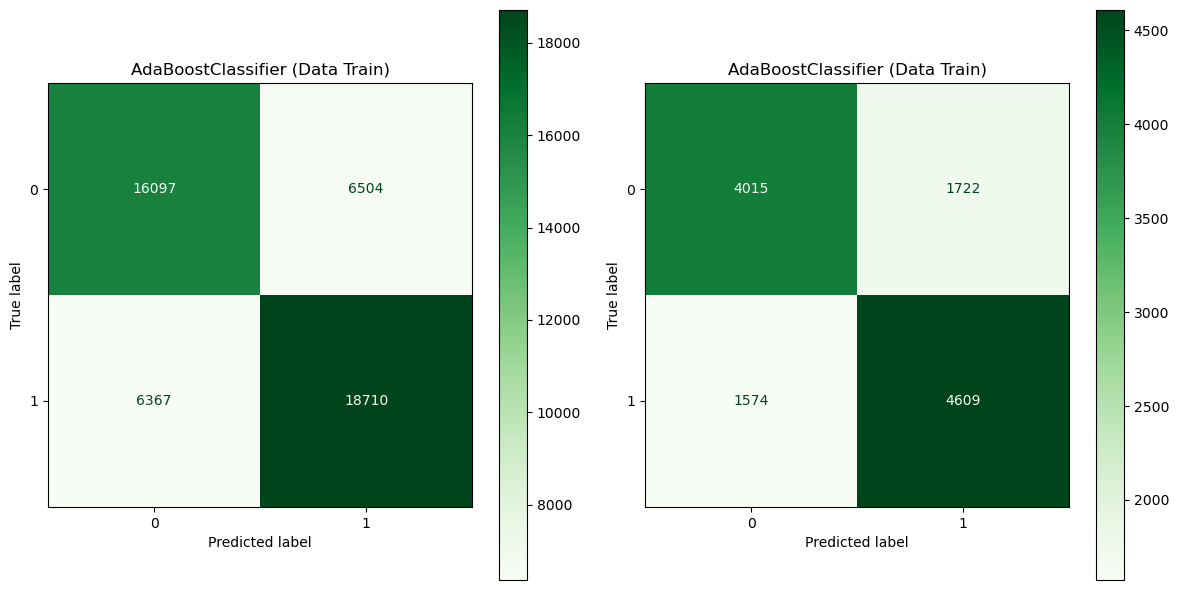

In [57]:
# Confusion Matrix
ada_tuned_cm = cm_display(best_ada_model, X_train_capped, y_train, X_test_capped, y_test)
ada_tuned_cm

Setelah dilakukan hyperparameter tuning, nilai confusion matrix dapat dilihat pada gambar tersebut. Insight yang didapatkan dari confusion matrix data test adalah sebagai berikut:
- Nilai TP dari confusion matrix tersebut adalah 4609. Meningkat dari nilai sebelumnya yaitu 4566
- Nilai TN yaitu 4015, mengalami penurunan sedikit dari nilai sebelumnya 4022
- Nilai FP yaitu 1722, meningkat dari nilai sebelumnya yaitu 1715
- Nilai FN yaitu 1574, mengalami penurunan dari nilai sebelumnya yaitu 1617

In [58]:
# Precision
print("Precision score - Train set:", round(precision_score(y_train, y_pred_train_tuned), 2))
print("Precision score - Test set:", round(precision_score(y_test, y_pred_test_tuned), 2))

Precision score - Train set: 0.74
Precision score - Test set: 0.73


(Score:  0.81) Fair


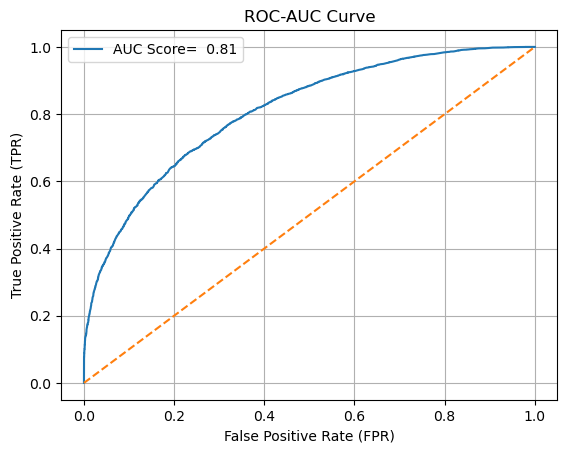

In [59]:
# ROC-AUC
ada_tuned_score = roc_auc(best_ada_model, X_test_capped, y_test)
ada_tuned_score

Berdasarkan ROC-AUC, score AUC yang diperoleh setelah hyperparameter tuning sama seperti score sebelumnya yaitu 0.81. Ini menunjukkan bahwa, baik sebelum dan sesudah dilakukan hyperparameter tuning, model masih dapat membedakan kedua kelas secara keseluruhan dengan baik.

**Perbandingan before-after tuning**

In [60]:
all_reports = {}
all_reports = performance_report(all_reports, y_train, y_pred_train, y_test, y_pred_test, "Model without Tuning")
all_reports = performance_report(all_reports, y_train, y_pred_train_tuned, y_test, y_pred_test_tuned, "Model with Tuning")

pd.DataFrame(all_reports)

,Model without Tuning,Model with Tuning
Precision Train Set,0.74,0.74
Precision Test Set,0.73,0.73
False Positive Train,6586.00,6504.00
False Positive Test,1715.00,1722.00


Dari insight tersebut, dapat disimpulkan bahwa model belum berhasil dalam meminimalisir nilai FP. Nilai FP yang didapatkan setelah hyperparameter tuning mengalami peningkatan dari yang awalnya 1715 menjadi 1722 (selisih 7). Score precision train dan test-nya pun sama, tidak mengalami overfitting maupun underfitting. Ini menunjukkan bahwa penambahan hyperparameter tidak terlalu berpengaruh terhadap performa model. Dengan hasil ini, model sebelum hyperparameter tuning dipilih untuk proses prediksi berikutnya. Karena meskipun score AUC dan precision tidak berubah, jumlah FP lebih rendah, yang lebih sesuai dengan fokus utama proyek ini.

## **MODEL SAVING**

Setelah evaluasi model berhasil dilakukan, kemudian model disimpan untuk memprediksi data inference.

In [61]:
with open('pipe_ada.pkl', 'wb') as model_file:
    pickle.dump(pipe_ada, model_file)

## **MODEL INFERENCE**

Model inference dilakukan di notebook yang berbeda.

## **KESIMPULAN**

Ada beberapa insight yang didapatkan setelah melalui berbagai proses pemodelan:
- Dari proses cross validation didapatkan best model yaitu AdaBoost Classifier. Ini menyimpulkan bahwa ensemble learning bisa mengatasi kelemahan base model dengan menggabungkan beberapa model yang lemah (weak learners) menjadi satu model yang lebih bagus, sehingga meningkatkan performa model dalam memprediksi data
- Karyawan yang termasuk FP, merupakan karyawan yang akan resign, namun model salah memprediksi sebagai karyawan yang akan stay. Berdasarkan objektif, lebih penting untuk tidak melewatkan karyawan yang berisiko resign, karena jika mereka tidak terdeteksi, tim HR tidak dapat mempertahankan mereka di awal
- Meskipun metrik precision bisa menyebabkan lebih banyak nilai FN (karyawan yang sebenarnya tetap stay, tapi diprediksi resign), biasanya dalam situasi ini FN masih lebih mudah ditangani oleh tim HR

Adapun rekomendasi yang bisa saya berikan yaitu:
- Setelah mengetahui jumlah karyawan yang termasuk FP, tim HR bisa melakukan pencegahan, seperti meningkatkan work-life balance (dengan opsi kerja yang fleksibel dan pengurangan lembur), penyesuaian gaji sesuai dengan standar industri, serta peluang pengembangan karir melalui bimbingan dan promosi.